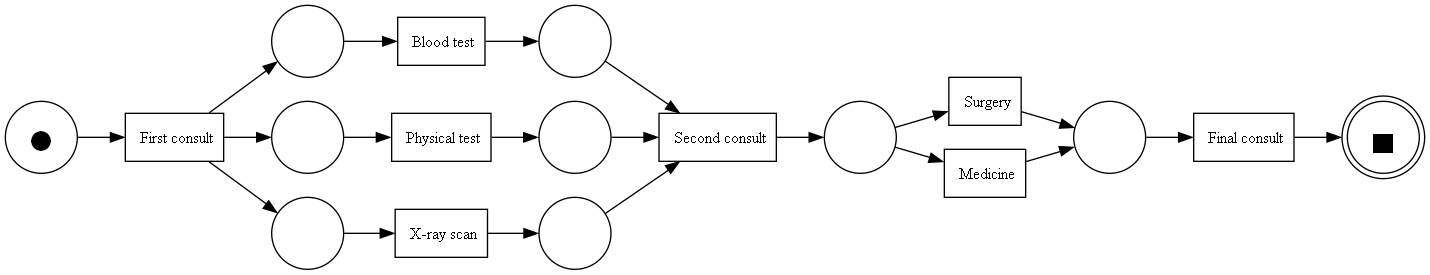

In [2]:
import pandas
import pm4py
from pm4py.objects.conversion.log import converter as log_converter 
from pm4py.objects.log.importer.xes import importer as xes_importer
event_log = pandas.read_csv("ArtificialPatientTreatment.csv" , sep=',')
event_log.rename(columns={' DateTime': 'time:timestamp', 
'patient': 'case:concept:name', ' action': 'concept:name', ' org:resource': 'org:resource'}, inplace=True)
log = log_converter.apply(event_log)
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(log)
from pm4py.visualization.petri_net import visualizer as pn_visualizer
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

In [3]:
#This function does not check the different aspects of a net (reachability, boundedness or Liveness) it checks if the net conforms to the nature
#of the real data, technically the nets are sound but may not conform to the way the log is presented
def checkNet(places, event_log_IDs):
    #Lists for seperating first and second transitions, lists for duplicates, 
    #indices, after and before transitions and counters to determine petri net
    IDs = list(dict.fromkeys(event_log_IDs.tolist()))
    placesF = []
    dupF = []
    dupS = []
    indicesF = []
    indicesS = []
    afterF = []
    beforeS = []
    placesS = []
    countF = 0
    countS = 0
    for i in places:
        #Removing 'start' and 'end' places, segregating First and Second transitions using the curly and regular brackets as a partition point
        if(str(i).startswith("({")):
            placesF.append(str(i).partition('}')[0].replace("({'" , '').replace("'", '').strip())
            placesS.append(str(i).partition('}')[2].replace(", {'" , '').replace("'})", '').strip())
    # Creating a list of duplicates in each transition list to cross-reference with the original log (if there are duplicates in the transition list this means that 
    # a transition would split into multiple places or multiple places would converge on one transition depending on which list the duplicate is in)
    dupF = list({x for x in placesF if placesF.count(x) > 1})
    dupS = list({x for x in placesF if placesS.count(x) > 1})
    #Creating an indices list with the same indices as the first transition duplicates, this is because the index of the duplicate will be the same as the index
    #of the transition after the duplicate.
    for x in dupF:
        indicesF = [i for i in range(len(placesF)) if placesF[i] == x]
        for i in indicesF:
            for m in placesS:
                #Using the newly created index list to create a list of the transitions after the duplicate
                if i == placesS.index(m):
                    afterF.append(placesS[i])
        #looping through all case IDs, creating a temporary list of transitions (events) for each case
        for id in IDs:
            TFlist = []
            for index, case in event_log.loc[event_log['case:concept:name'] == id].iterrows():
                TFlist.append(case['concept:name'].strip())
            #Finally we check the list of transitions after the duplicate by comparing it the original data, we check it for each case
            #If one of the cases does not have one of the events (transitions) then the we increment the counter
            for after in afterF:
                if after not in TFlist:
                    countF = countF + 1
            #if the counter > 0 then there is a problem with the petri net
            if countF > 0:
                print(countF)
                print('Problem located after ' + x)
                break
    #Similar to the previous loop but for the next set of transitions, we check if the transitions before the duplicates are in every case
    for x in dupS:
        indicesS = [i for i in range(len(placesS)) if placesS[i] == x]
        for i in indicesS:
            for m in placesF:
                if i == placesF.index(m):
                    beforeS.append(placesF[i])
        for id in IDs:
            TSlist = []
            for index, case in event_log.loc[event_log['case:concept:name'] == id].iterrows():
                TSlist.append(case['concept:name'].strip())
            for before in beforeS:
                if before not in TSlist:
                    countS = countS + 1
            if countS > 0:
                print(countS)
                print('Problem located before ' + x)
                break

In [4]:
#Checking net algorithm used
checkNet(net.places, event_log['case:concept:name'])

1
Problem located after First consult
1
Problem located before Second consult


   case:concept:name     concept:name  org:resource        time:timestamp
0                  0    First consult      Dr. Anna   2017-01-02 11:40:11
1                  0       Blood test           Lab   2017-01-02 12:47:33
2                  0    Physical test   Nurse Jesse   2017-01-02 12:53:50
3                  0   Second consult      Dr. Anna   2017-01-02 16:21:06
4                  0          Surgery   Dr. Charlie   2017-01-05 13:23:09
5                  0    Final consult       Dr. Ben   2017-01-09 08:29:28
    case:concept:name     concept:name  org:resource        time:timestamp
6                   1    First consult      Dr. Anna   2017-01-02 12:50:35
7                   1    Physical test   Nurse Jesse   2017-01-02 13:59:14
8                   1       Blood test           Lab   2017-01-02 14:20:19
9                   1       X-ray scan        Team 1   2017-01-06 09:13:40
10                  1   Second consult      Dr. Anna   2017-01-06 10:38:04
11                  1         Me

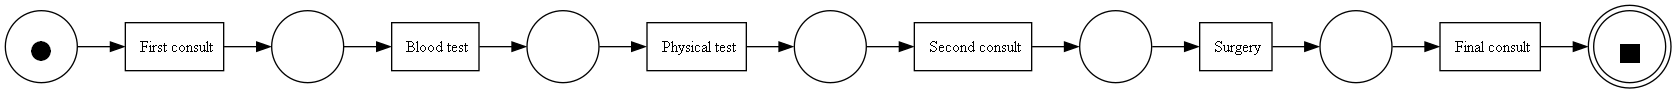

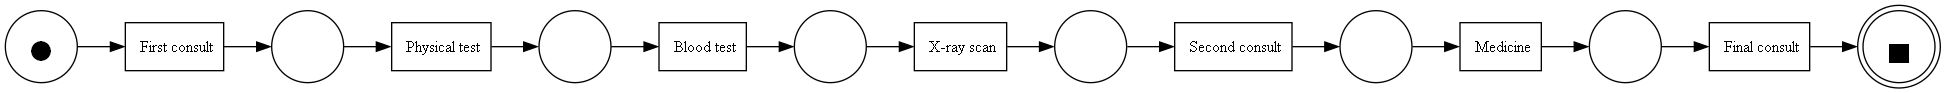

In [5]:
#Patient 0 event log and net
case = event_log.loc[event_log['case:concept:name'] == 0]
type(case)
logZ = log_converter.apply(case)
print(case)
netZ, initial_markingZ, final_markingZ = alpha_miner.apply(logZ)
#Patient 1 event log and net
caseO = event_log.loc[event_log['case:concept:name'] == 1]
logO = log_converter.apply(caseO)
print(caseO)
netO, initial_markingO, final_markingO = alpha_miner.apply(logO)
#Patient 0 net visualization
gvizZ = pn_visualizer.apply(netZ, initial_markingZ, final_markingZ) 
pn_visualizer.view(gvizZ)
#Patient 1 net visualization
gvizO = pn_visualizer.apply(netO, initial_markingO, final_markingO) 
pn_visualizer.view(gvizO)

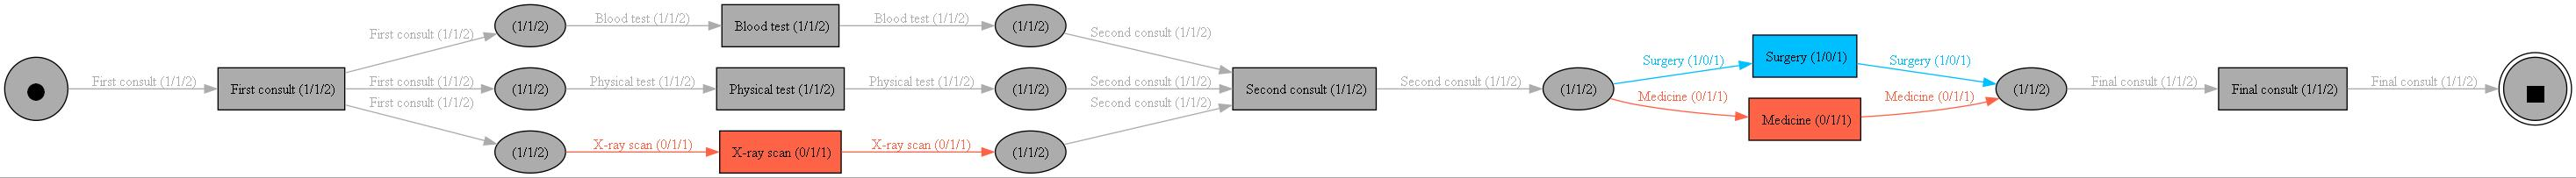

In [7]:
#comparison between patient 0 and patien 1 event log and visualization on base net
from pm4py.algo.comparison.petrinet import element_usage_comparison as comparison
comp = comparison.compare_element_usage_two_logs(net, initial_marking, final_marking, logZ, logO)
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "jpg"}
gvizC = pn_visualizer.apply(net, initial_marking, final_marking, log={logZ,logO} , aggregated_statistics=comp , parameters=parameters,variant=pn_visualizer.Variants.FREQUENCY) 
pn_visualizer.view(gvizC)